# Embedding large data sets

Embedding large data sets typically requires more care. Using various tricks described in *preserving_global_structure* can become quite slow to run. Instead, we can take a smaller, manageable sample of our data set, obtain a good visualization of that. Then, we can add the remaining points to the embedding and use that as our initialization.

Remember that the initialization largely affects the structure of the embedding. This way, our initialization provides the global structure for the embedding, and the subsequent optimization can focus on preserving local strucutre.

In [1]:
import gzip
import pickle

import numpy as np
import openTSNE
from examples import utils

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
%%time
with gzip.open("data/10x_mouse_zheng.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"]

CPU times: user 4.73 s, sys: 980 ms, total: 5.71 s
Wall time: 5.71 s


In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 1306127 samples with 50 features


In [4]:
def plot(x, y, **kwargs):
    fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
    alpha = kwargs.pop("alpha", 0.1)
    utils.plot(
        x,
        np.zeros_like(y),
        ax=ax[0],
        colors={0: "k"},
        alpha=alpha,
        draw_legend=False,
        **kwargs,
    )
    utils.plot(
        x,
        y,
        ax=ax[1],
        colors=utils.MOUSE_10X_COLORS,
        alpha=alpha,
        draw_legend=False,
        **kwargs,
    )

In [5]:
def rotate(degrees):
    phi = degrees * np.pi / 180
    return np.array([
        [np.cos(phi), -np.sin(phi)],
        [np.sin(phi), np.cos(phi)],
    ])

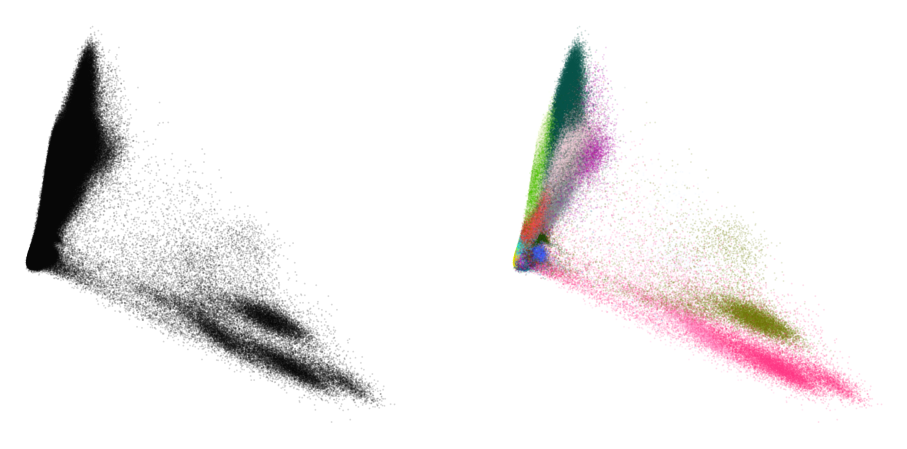

In [6]:
plot(x, y)

We'll also precompute the full affinities, since we'll be needing it in several places throughout the notebook, and can take a long time to run.

In [7]:
%%time
aff50 = openTSNE.affinity.PerplexityBasedNN(
    x,
    perplexity=50,
    n_jobs=32,
    random_state=0,
)

CPU times: user 46min 53s, sys: 1min 39s, total: 48min 33s
Wall time: 5min 35s


In [8]:
%%time
aff500 = openTSNE.affinity.PerplexityBasedNN(
    x,
    perplexity=500,
    n_jobs=32,
    random_state=0,
)

CPU times: user 4h 54min 10s, sys: 4min 44s, total: 4h 58min 55s
Wall time: 22min 23s


## Standard t-SNE

First, let's see what standard t-SNE does.

In [9]:
# Because we're given the data representation as the top 50 principal components
# we can just use the top 2 components as the initilization. There is no sense in
# calculating PCA on a PCA representation
init = openTSNE.initialization.rescale(x[:, :2])

In [10]:
%%time
embedding_standard = openTSNE.TSNE(
    n_jobs=32,
    verbose=True,
).fit(affinities=aff50, initialization=init)

--------------------------------------------------------------------------------
TSNE(n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=108843.92 for 250 iterations...
Iteration   50, KL divergence 8.9036, 50 iterations in 43.6444 sec
Iteration  100, KL divergence 8.1739, 50 iterations in 45.7009 sec
Iteration  150, KL divergence 7.9832, 50 iterations in 45.4050 sec
Iteration  200, KL divergence 7.8977, 50 iterations in 43.9690 sec
Iteration  250, KL divergence 7.8511, 50 iterations in 44.4052 sec
   --> Time elapsed: 223.13 seconds
===> Running optimization with exaggeration=1.00, lr=108843.92 for 500 iterations...
Iteration   50, KL divergence 6.4946, 50 iterations in 43.9199 sec
Iteration  100, KL divergence 5.9617, 50 iterations in 43.6204 sec
Iteration  150, KL divergence 5.6756, 50 iterations in 44.2530 sec
Iteration  200, KL divergence 5.4932, 50 iterations in 45.1531 se

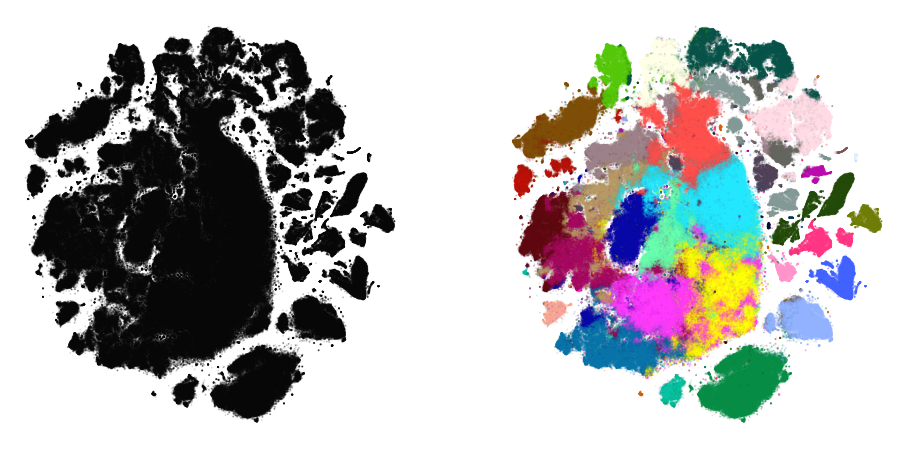

In [11]:
plot(embedding_standard, y)

This doesn't look too great. The cluster separation is quite poor and the visualization is visually not very appealing.

## Using larger exaggeration

Exaggeration can be used in order to get better separation between clusters. Let's see if that helps.

In [12]:
%%time
embedding_exag = openTSNE.TSNE(
    exaggeration=4,
    n_jobs=32,
    verbose=True,
).fit(affinities=aff50, initialization=init)

--------------------------------------------------------------------------------
TSNE(exaggeration=4, n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=108843.92 for 250 iterations...
Iteration   50, KL divergence 8.9036, 50 iterations in 41.3583 sec
Iteration  100, KL divergence 8.1739, 50 iterations in 44.0357 sec
Iteration  150, KL divergence 7.9831, 50 iterations in 44.8030 sec
Iteration  200, KL divergence 7.8978, 50 iterations in 44.5963 sec
Iteration  250, KL divergence 7.8511, 50 iterations in 44.0719 sec
   --> Time elapsed: 218.87 seconds
===> Running optimization with exaggeration=4.00, lr=108843.92 for 500 iterations...
Iteration   50, KL divergence 7.0117, 50 iterations in 44.1787 sec
Iteration  100, KL divergence 6.8478, 50 iterations in 44.2544 sec
Iteration  150, KL divergence 6.7850, 50 iterations in 43.0467 sec
Iteration  200, KL divergence 6.7506, 50 iteratio

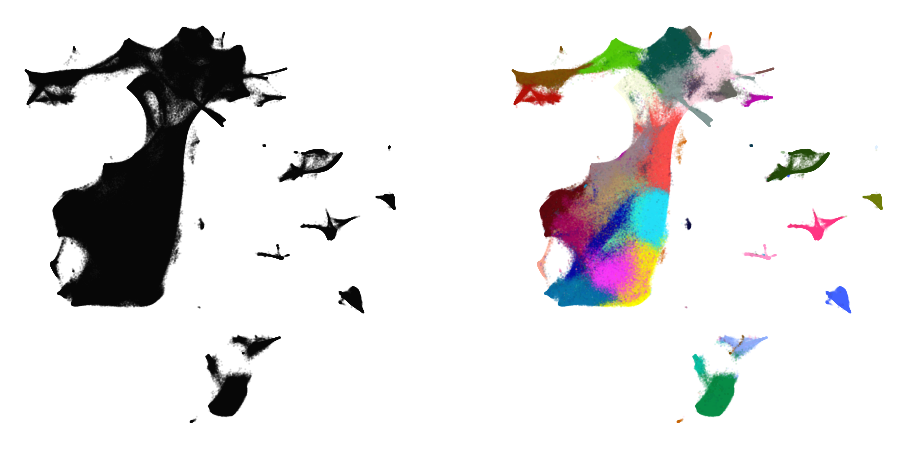

In [13]:
plot(embedding_exag, y)

The separation has improved quite a bit, but many clusters are still intertwined with others.

## Using a larger perplexity

In [14]:
%%time
embedding_aff500 = openTSNE.TSNE(
    n_jobs=32,
    verbose=True,
).fit(affinities=aff500, initialization=init)

--------------------------------------------------------------------------------
TSNE(n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=108843.92 for 250 iterations...
Iteration   50, KL divergence 6.6121, 50 iterations in 155.4301 sec
Iteration  100, KL divergence 6.0752, 50 iterations in 155.6532 sec
Iteration  150, KL divergence 5.9787, 50 iterations in 155.2036 sec
Iteration  200, KL divergence 5.9415, 50 iterations in 158.4592 sec
Iteration  250, KL divergence 5.9224, 50 iterations in 164.1987 sec
   --> Time elapsed: 788.95 seconds
===> Running optimization with exaggeration=1.00, lr=108843.92 for 500 iterations...
Iteration   50, KL divergence 4.4697, 50 iterations in 156.9712 sec
Iteration  100, KL divergence 4.0495, 50 iterations in 157.9296 sec
Iteration  150, KL divergence 3.8464, 50 iterations in 168.0550 sec
Iteration  200, KL divergence 3.7248, 50 iterations in 16

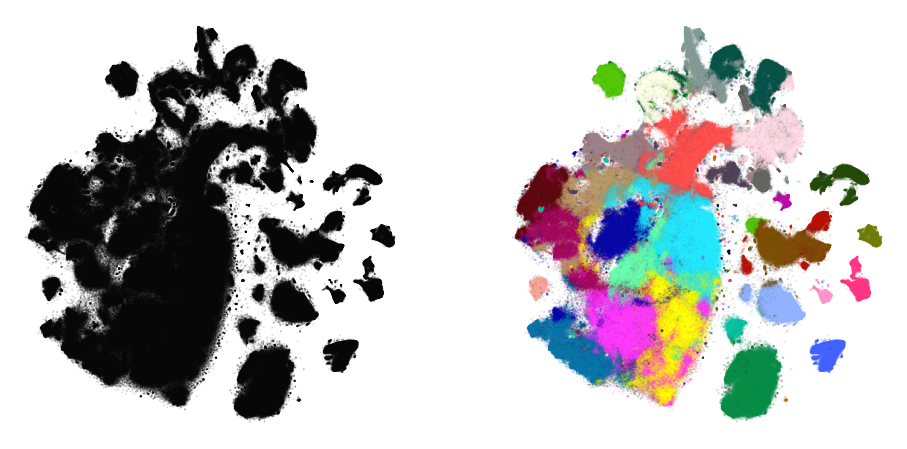

In [15]:
plot(embedding_aff500, y)

## ... with higher exaggeration

In [16]:
%%time
embedding_aff500_exag4 = openTSNE.TSNE(
    exaggeration=4,
    n_jobs=32,
    verbose=True,
).fit(affinities=aff500, initialization=init)

--------------------------------------------------------------------------------
TSNE(exaggeration=4, n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=108843.92 for 250 iterations...
Iteration   50, KL divergence 6.6121, 50 iterations in 165.1051 sec
Iteration  100, KL divergence 6.0752, 50 iterations in 170.2804 sec
Iteration  150, KL divergence 5.9787, 50 iterations in 167.2433 sec
Iteration  200, KL divergence 5.9415, 50 iterations in 167.1109 sec
Iteration  250, KL divergence 5.9224, 50 iterations in 166.6234 sec
   --> Time elapsed: 836.37 seconds
===> Running optimization with exaggeration=4.00, lr=108843.92 for 500 iterations...
Iteration   50, KL divergence 5.0955, 50 iterations in 165.1969 sec
Iteration  100, KL divergence 4.9934, 50 iterations in 167.7396 sec
Iteration  150, KL divergence 4.9625, 50 iterations in 166.0314 sec
Iteration  200, KL divergence 4.9504, 50 

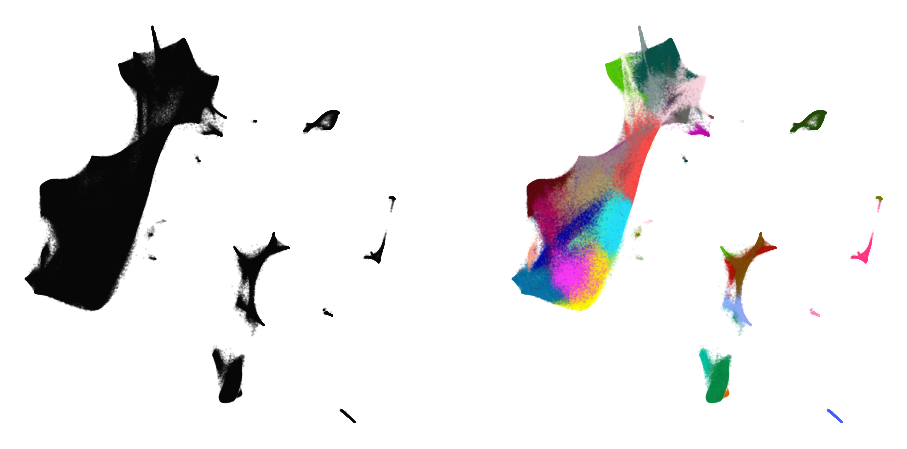

In [17]:
plot(embedding_aff500_exag4, y)

## Initialize via downsampling

We now perform the sample-transform trick we described above.

### Create train/test split

In [18]:
np.random.seed(0)

In [19]:
indices = np.random.permutation(list(range(x.shape[0])))
reverse = np.argsort(indices)

x_sample, x_rest = x[indices[:25000]], x[indices[25000:]]
y_sample, y_rest = y[indices[:25000]], y[indices[25000:]]

### Create sample embedding

In [20]:
%%time
sample_affinities = openTSNE.affinity.PerplexityBasedNN(
    x_sample,
    perplexity=500,
    n_jobs=32,
    random_state=0,
    verbose=True,
)

===> Finding 1500 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 14.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 5.66 seconds
CPU times: user 4min 17s, sys: 3.09 s, total: 4min 20s
Wall time: 19.7 s


In [21]:
%time sample_init = openTSNE.initialization.pca(x_sample, random_state=42)

CPU times: user 1.66 s, sys: 96 ms, total: 1.76 s
Wall time: 86.1 ms


In [22]:
%time sample_embedding = openTSNE.TSNE(n_jobs=32, verbose=True).fit(affinities=sample_affinities, initialization=sample_init)

--------------------------------------------------------------------------------
TSNE(n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=2083.33 for 250 iterations...
Iteration   50, KL divergence 3.2514, 50 iterations in 2.8158 sec
Iteration  100, KL divergence 3.0818, 50 iterations in 2.8074 sec
Iteration  150, KL divergence 3.0695, 50 iterations in 2.8865 sec
Iteration  200, KL divergence 3.0668, 50 iterations in 2.7726 sec
Iteration  250, KL divergence 3.0662, 50 iterations in 2.6979 sec
   --> Time elapsed: 13.98 seconds
===> Running optimization with exaggeration=1.00, lr=2083.33 for 500 iterations...
Iteration   50, KL divergence 1.4430, 50 iterations in 2.8882 sec
Iteration  100, KL divergence 1.2700, 50 iterations in 2.7344 sec
Iteration  150, KL divergence 1.2087, 50 iterations in 2.7087 sec
Iteration  200, KL divergence 1.1795, 50 iterations in 2.8707 sec
Iteration  2

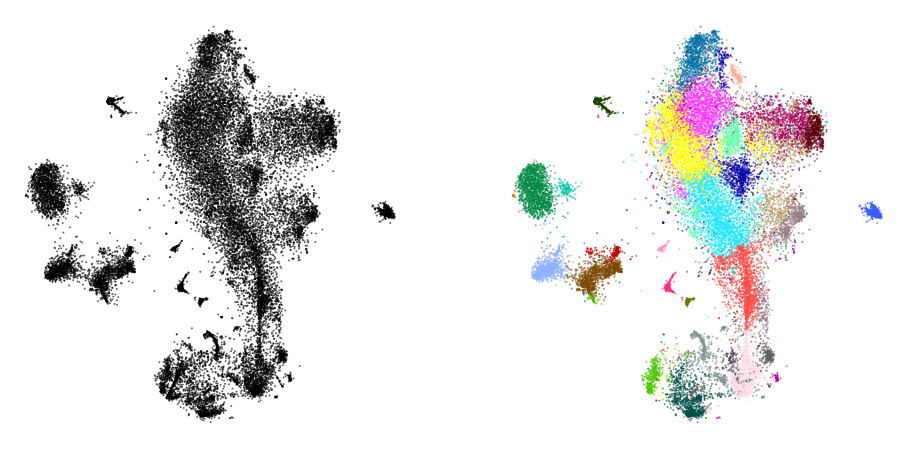

In [23]:
plot(sample_embedding, y[indices[:25000]], alpha=0.5)

### Learn the full embedding

In [24]:
%time rest_init = sample_embedding.prepare_partial(x_rest, k=1, perplexity=1/3)

===> Finding 1 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 253.76 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.93 seconds
CPU times: user 6min 35s, sys: 41.5 s, total: 7min 16s
Wall time: 4min 14s


In [25]:
init_full = np.vstack((sample_embedding, rest_init))[reverse]

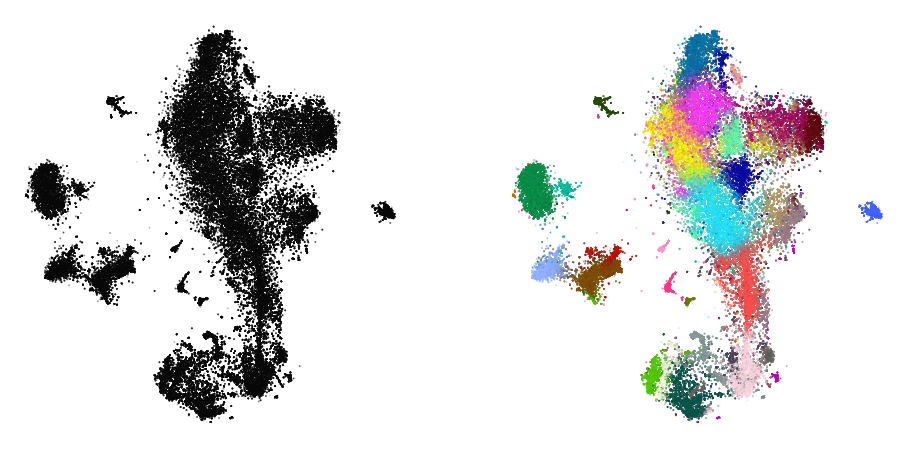

In [26]:
plot(init_full, y)

In [27]:
init_full = init_full / (np.std(init_full[:, 0]) * 10000)
np.std(init_full, axis=0)

array([1.00000000e-04, 1.15557926e-04])

In [28]:
embedding = openTSNE.TSNEEmbedding(
    init_full,
    aff50,
    n_jobs=32,
    verbose=True,
    random_state=42,
)

In [29]:
%time embedding1 = embedding.optimize(n_iter=500, exaggeration=12, momentum=0.5)

===> Running optimization with exaggeration=12.00, lr=108843.92 for 500 iterations...
Iteration   50, KL divergence 8.6100, 50 iterations in 43.9514 sec
Iteration  100, KL divergence 8.0667, 50 iterations in 46.7819 sec
Iteration  150, KL divergence 7.9223, 50 iterations in 45.6121 sec
Iteration  200, KL divergence 7.8557, 50 iterations in 45.4719 sec
Iteration  250, KL divergence 7.8177, 50 iterations in 45.1488 sec
Iteration  300, KL divergence 7.7932, 50 iterations in 45.0411 sec
Iteration  350, KL divergence 7.7764, 50 iterations in 44.9336 sec
Iteration  400, KL divergence 7.7640, 50 iterations in 44.5941 sec
Iteration  450, KL divergence 7.7548, 50 iterations in 44.5967 sec
Iteration  500, KL divergence 7.7478, 50 iterations in 44.8961 sec
   --> Time elapsed: 451.03 seconds
CPU times: user 2h 21min 31s, sys: 3min 51s, total: 2h 25min 23s
Wall time: 7min 33s


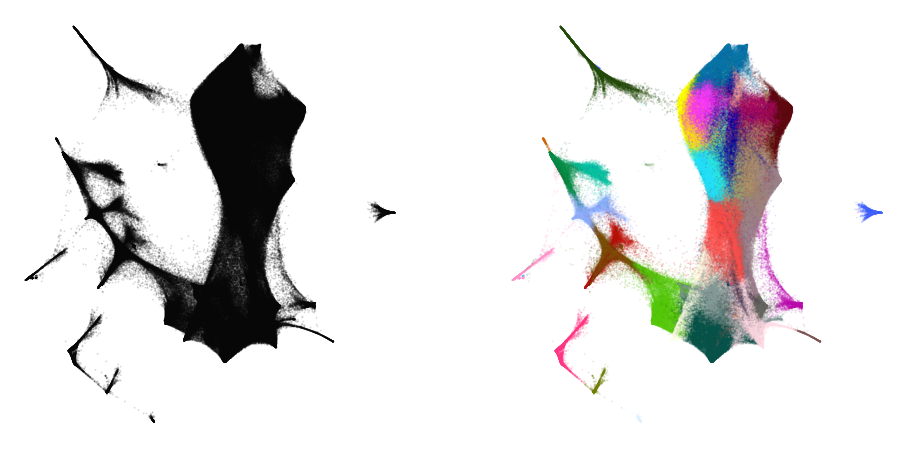

In [30]:
plot(embedding1, y)

In [31]:
%time embedding2 = embedding1.optimize(n_iter=250, exaggeration=4, momentum=0.8)

===> Running optimization with exaggeration=4.00, lr=108843.92 for 250 iterations...
Iteration   50, KL divergence 6.9774, 50 iterations in 45.0601 sec
Iteration  100, KL divergence 6.8239, 50 iterations in 44.5858 sec
Iteration  150, KL divergence 6.7657, 50 iterations in 43.4053 sec
Iteration  200, KL divergence 6.7341, 50 iterations in 43.8213 sec
Iteration  250, KL divergence 6.7131, 50 iterations in 43.4168 sec
   --> Time elapsed: 220.29 seconds
CPU times: user 1h 10min 33s, sys: 1min 56s, total: 1h 12min 30s
Wall time: 3min 42s


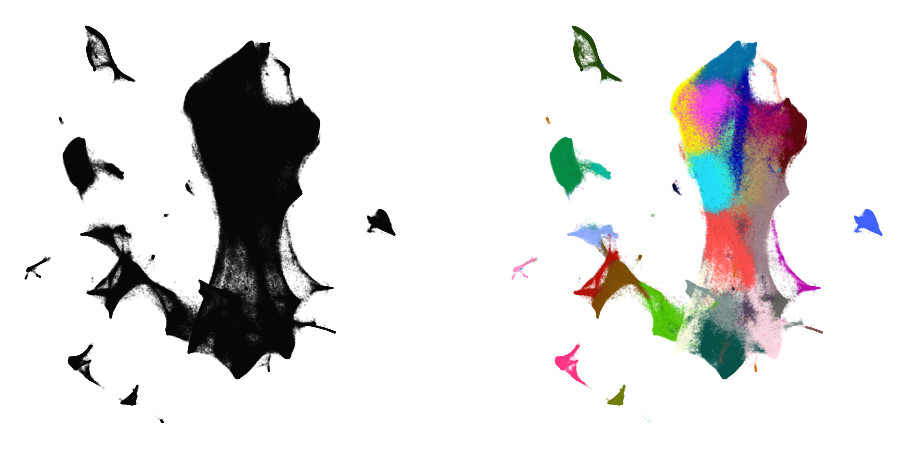

In [32]:
plot(embedding2, y)

In [33]:
%time embedding3 = embedding2.optimize(n_iter=250, exaggeration=4, momentum=0.8)

===> Running optimization with exaggeration=4.00, lr=108843.92 for 250 iterations...
Iteration   50, KL divergence 6.6988, 50 iterations in 42.4042 sec
Iteration  100, KL divergence 6.6849, 50 iterations in 41.8349 sec
Iteration  150, KL divergence 6.6753, 50 iterations in 42.8223 sec
Iteration  200, KL divergence 6.6687, 50 iterations in 41.5115 sec
Iteration  250, KL divergence 6.6634, 50 iterations in 41.6096 sec
   --> Time elapsed: 210.19 seconds
CPU times: user 1h 6min 54s, sys: 1min 54s, total: 1h 8min 49s
Wall time: 3min 32s


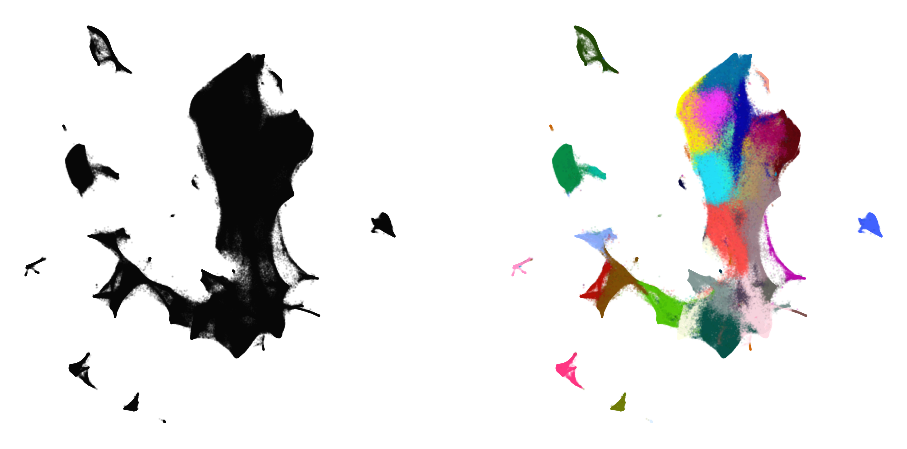

In [34]:
plot(embedding3, y)

In [35]:
%time embedding4 = embedding3.optimize(n_iter=250, exaggeration=4, momentum=0.8)

===> Running optimization with exaggeration=4.00, lr=108843.92 for 250 iterations...
Iteration   50, KL divergence 6.6576, 50 iterations in 41.6053 sec
Iteration  100, KL divergence 6.6519, 50 iterations in 41.5500 sec
Iteration  150, KL divergence 6.6474, 50 iterations in 41.7626 sec
Iteration  200, KL divergence 6.6439, 50 iterations in 42.2903 sec
Iteration  250, KL divergence 6.6410, 50 iterations in 41.6484 sec
   --> Time elapsed: 208.86 seconds
CPU times: user 1h 7min 27s, sys: 1min 55s, total: 1h 9min 23s
Wall time: 3min 30s


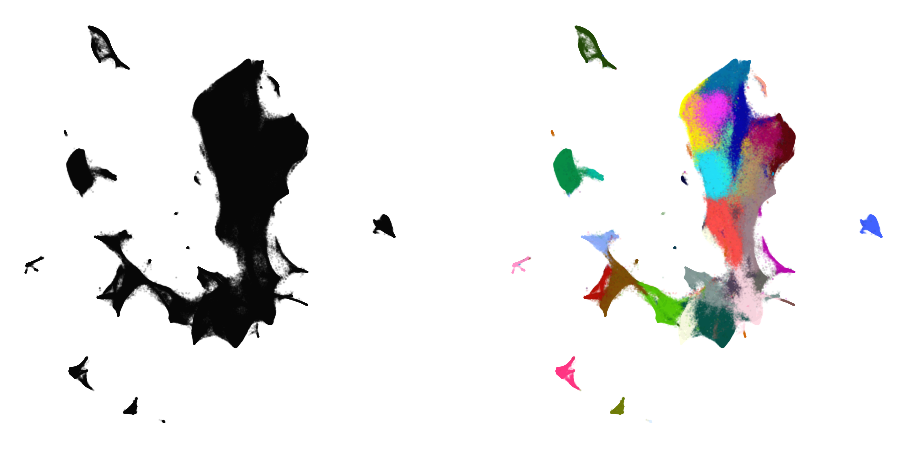

In [36]:
plot(embedding4, y)

## Comparison to UMAP

In [37]:
from umap import UMAP

In [38]:
umap = UMAP(n_neighbors=15, min_dist=0.1, random_state=1)

In [39]:
%time embedding_umap = umap.fit_transform(x)

/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../local/miniconda3/envs/tsne/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.

CPU times: user 6h 30min 53s, sys: 9min 34s, total: 6h 40min 27s
Wall time: 1h 6min 49s


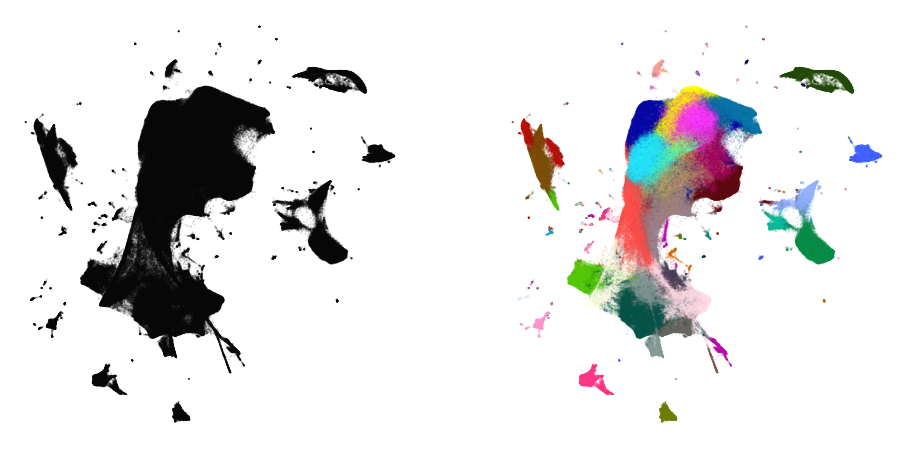

In [40]:
plot(embedding_umap, y)